In [1]:
from typing import Dict
import numpy as np
# from omegaconf import DictConfig, ListConfig
import torch
from torch.utils.data import Dataset
from pathlib import Path
import json
from PIL import Image
from torchvision import transforms
from einops import rearrange
# from ldm.util import instantiate_from_config
# from datasets import load_dataset
import copy
import csv
import cv2
import os
import math
import random
import matplotlib.pyplot as plt

In [2]:
def make_tranforms(image_transforms):
#     if isinstance(image_transforms, ListConfig):
#         image_transforms = [instantiate_from_config(tt) for tt in image_transforms]
    image_transforms.extend([transforms.ToTensor(),
                                transforms.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])
    image_transforms = transforms.Compose(image_transforms)
    return image_transforms

In [9]:
class ObjaverseData(Dataset):
    def __init__(self,
        root_dir='/home/rliu/Desktop/cvfiler04/datasets/objaverse/hf-objaverse-v1/views',
        image_transforms=[],
        ext="png",
        default_trans=torch.zeros(3),
        postprocess=None,
        return_paths=False,
        total_view=4,
        validation=False,
        ) -> None:
        """Create a dataset from a folder of images.
        If you pass in a root directory it will be searched for images
        ending in ext (ext can be a list)
        """
        self.root_dir = Path(root_dir)
        self.default_trans = default_trans
        self.return_paths = return_paths
#         if isinstance(postprocess, DictConfig):
#             postprocess = instantiate_from_config(postprocess)
        self.postprocess = postprocess
        self.total_view = total_view

        with open(os.path.join(root_dir, 'valid_paths.json')) as f:
            self.paths = json.load(f)
        
#         if not isinstance(ext, (tuple, list, ListConfig)):
#             ext = [ext]

        # Only used if there is no caption file
        self.paths = os.listdir(self.root_dir)
        total_objects = len(self.paths)
        if validation:
            self.paths = self.paths[math.floor(total_objects / 100. * 99.):] # used last 1% as validation
        else:
            self.paths = self.paths[:math.floor(total_objects / 100. * 99.)] # used first 99% as training
        self.tform = make_tranforms(image_transforms)

    def __len__(self):
        if self.captions is not None:
            return len(self.captions.keys())
        else:
            return len(self.paths)
        
    def get_T(target_RT, cond_RT):
        R, T = target_RT[:3, :3], target_RT[:, -1]
        T_target = -R.T @ T

        R, T = cond_RT[:3, :3], cond_RT[:, -1]
        T_cond = -R.T @ T

        theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])
        theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])

        d_theta = theta_target - theta_cond
        d_azimuth = (azimuth_target - azimuth_cond) % (2 * math.pi)
        d_z = z_target - z_cond

        d_T = torch.tensor([d_theta.item(), math.sin(d_azimuth), math.cos(d_azimuth), d_z.item()])
        return d_T

    def load_im(self, path):
        target_im = plt.imread(path)
        target_im[target_im[:, :, -1] == 0.] = [1., 1., 1., 1.]
        target_im = Image.fromarray(np.uint8(target_im[:, :, :3] * 255.))
        return target_im

    def __getitem__(self, index):
        data = {}
        index_target, index_cond = random.sample(range(self.total_view), 2) # without replacement
        filename = os.path.join(self.root_dir, self.paths[index])

        if self.return_paths:
            data["path"] = str(filename)
            
        target_im = self.process_im(self.load_im(os.path.join(filename, '%03d.png' % index_target)))
        target_RT = np.load(os.path.join(filename, '%03d.npy' % index_target))
        cond_im = self.process_im(self.load_im(os.path.join(filename, '%03d.png' % index_cond)))
        cond_RT = np.load(os.path.join(filename, '%03d.npy' % index_cond))

        data["image_target"] = target_im
        data["image_cond"] = cond_im
#         data["T"] = get_T(target_RT, cond_RT)

        if self.postprocess is not None:
            data = self.postprocess(data)

        return data

    def process_im(self, im):
        im = im.convert("RGB")
        return self.tform(im)

In [10]:
dataset = ObjaverseData(root_dir='/local/vondrick/ruoshi/objaverse/views_whole_sphere_merged', return_paths=True)

In [12]:
dataset[0]['image_target'].shape

torch.Size([512, 512, 3])

# representing transformation with x, y, z

In [16]:
def load_im(path):
    target_im = plt.imread(path)
    target_im[target_im[:, :, -1] == 0.] = [1., 1., 1., 1.]
    target_im = Image.fromarray(np.uint8(target_im[:, :, :3] * 255.))
    return target_im

def get_T(target_RT, cond_RT):
    R, T = target_RT[:3, :3], target_RT[:, -1]
    T_target = -R.T @ T

    R, T = cond_RT[:3, :3], cond_RT[:, -1]
    T_cond = -R.T @ T

    z = -T_cond
    x = np.cross(z, np.array([0, 0, -1]))
    y = np.cross(z, x)
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    z = z / np.linalg.norm(z)

    v = T_target - T_cond

    v_x = np.dot(v, x)
    v_y = np.dot(v, y)
    v_z = np.dot(v, z)

    return torch.tensor([v_x, v_y, v_z])

In [17]:
index_target, index_cond = random.sample(range(4), 2)

In [18]:
root_dir = '/home/rliu/Desktop/cvfiler04/datasets/objaverse/hf-objaverse-v1/views_whole_sphere'
filename = os.path.join(root_dir, '94d5a26aea644af2b7ad65b116dca7eb')
target_im = load_im(os.path.join(filename, '%03d.png' % index_target))
target_RT = np.load(os.path.join(filename, '%03d.npy' % index_target))
cond_im = load_im(os.path.join(filename, '%03d.png' % index_cond))
cond_RT = np.load(os.path.join(filename, '%03d.npy' % index_cond))
T = get_T(target_RT, cond_RT)

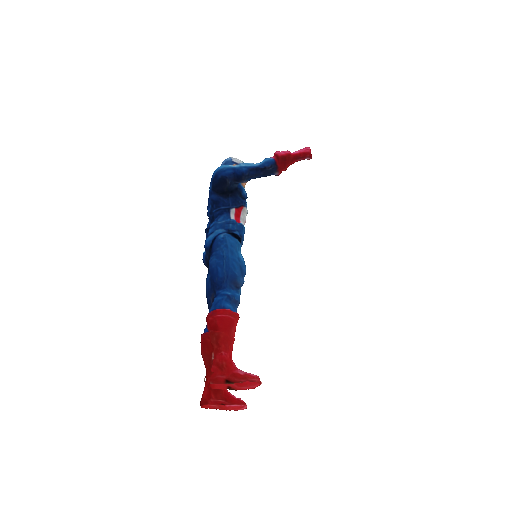

In [19]:
target_im

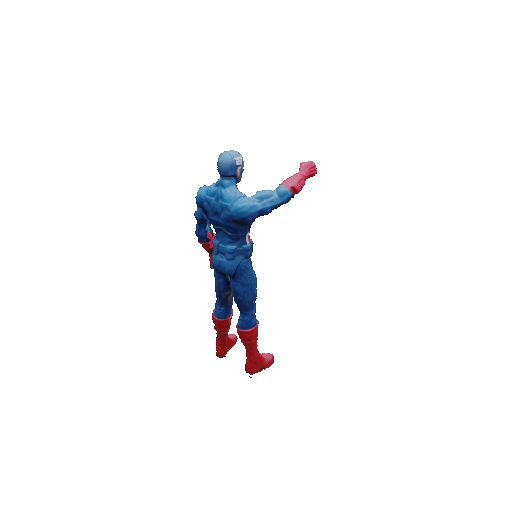

In [20]:
cond_im

In [21]:
R, T = target_RT[:3, :3], target_RT[:, -1]
T_target = -R.T @ T
T_target, np.linalg.norm(T_target)

(array([-1.44681641, -0.24003703, -0.89365552]), 1.7174154069309528)

In [22]:
R, T = cond_RT[:3, :3], cond_RT[:, -1]
T_cond = -R.T @ T
T_cond, np.linalg.norm(T_cond)

(array([-1.49810174,  0.84997026,  1.10401037]), 2.0458732077985418)

In [277]:
T_target - T_cond

array([-0.40072901, -0.10735473,  0.60105934])

In [278]:
z = -T_cond
x = np.cross(z, np.array([0, 0, -1]))
y = np.cross(z, x)
x = x / np.linalg.norm(x)
y = y / np.linalg.norm(y)
z = z / np.linalg.norm(z)

In [279]:
v = T_target - T_cond

In [280]:
v_x = np.dot(v, x)
v_y = np.dot(v, y)
v_z = np.dot(v, z)

In [281]:
v_x, v_y, v_z

(0.19118473931902488, 0.632949957336868, 0.31016745325467976)

In [43]:
dataset[0]

{'image_target': tensor([[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]

# representing transformation with \theta \phi z

In [14]:
import numpy as np

def cartesian_to_spherical(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    z = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    azimuth = np.arctan2(xyz[:,1], xyz[:,0])
    return np.array([theta, azimuth, z])

def load_im(path):
    target_im = plt.imread(path)
    target_im[target_im[:, :, -1] == 0.] = [1., 1., 1., 1.]
    target_im = Image.fromarray(np.uint8(target_im[:, :, :3] * 255.))
    return target_im

def get_T(target_RT, cond_RT):
    R, T = target_RT[:3, :3], target_RT[:, -1]
    T_target = -R.T @ T

    R, T = cond_RT[:3, :3], cond_RT[:, -1]
    T_cond = -R.T @ T

    theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])
    theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])
    
    d_theta = theta_target - theta_cond
    d_azimuth = (azimuth_target - azimuth_cond) % (2 * math.pi)
    d_z = z_target - z_cond
    
    d_T = torch.tensor([d_theta.item(), math.sin(d_azimuth), math.cos(d_azimuth), d_z.item()])
    return d_T

In [83]:
index_target, index_cond = random.sample(range(4), 2)

In [84]:
root_dir = '/home/rliu/Desktop/cvfiler04/datasets/objaverse/hf-objaverse-v1/views_whole_sphere'
# filename = os.path.join(root_dir, '58cf8b8fba1140a3ad502e162765f4cf')
# filename = os.path.join(root_dir, 'c0c9e216178f4ba489c085c0829db562')
filename = os.path.join(root_dir, '94d57137012148afaa9a2339a8fa30cb')
target_im = load_im(os.path.join(filename, '%03d.png' % index_target))
target_RT = np.load(os.path.join(filename, '%03d.npy' % index_target))
cond_im = load_im(os.path.join(filename, '%03d.png' % index_cond))
cond_RT = np.load(os.path.join(filename, '%03d.npy' % index_cond))
T = get_T(target_RT, cond_RT)

In [85]:
R, T = target_RT[:3, :3], target_RT[:, -1]
T_target = -R.T @ T
T_target, np.linalg.norm(T_target)

(array([0.76581714, 1.72942949, 0.0914474 ]), 1.8936115995820406)

In [86]:
R, T = cond_RT[:3, :3], cond_RT[:, -1]
T_cond = -R.T @ T
T_cond, np.linalg.norm(T_cond)

(array([ 0.47762456, -0.18480237, -1.53358741]), 1.6168387316708108)

[ 0.47762456 -0.18480237 -1.53358741]


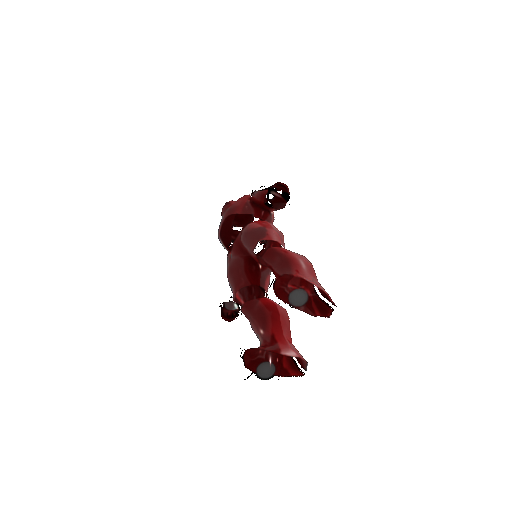

In [87]:
print(T_cond)
cond_im

[0.76581714 1.72942949 0.0914474 ]


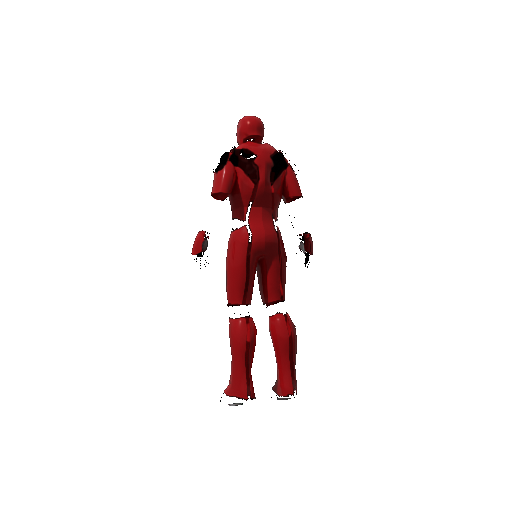

In [88]:
print(T_target)
target_im

In [91]:
get_T(T_target[None, :], T_cond[None, :])

array([-68.76560683, 267.26796124,  -2.30639766])

In [104]:
T_target = np.array([-1, 1, 1.0])
T_cond = np.array([1, 1, 1.0])

In [105]:
get_T(T_target[None, :], T_cond[None, :])

array([ 0., 90.,  0.])

In [21]:
import numpy as np

def cartesian_to_spherical(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    z = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    azimuth = np.arctan2(xyz[:,1], xyz[:,0])
    return np.array([theta, azimuth, z])

In [90]:
def get_T(target_RT, cond_RT):
    R, T = target_RT[:3, :3], target_RT[:, -1]
    T_target = -R.T @ T

    R, T = cond_RT[:3, :3], cond_RT[:, -1]
    T_cond = -R.T @ T

    theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])
    theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])
    
    d_theta = theta_target - theta_cond
    d_azimuth = (azimuth_target - azimuth_cond) % (2 * math.pi)
    d_z = z_target - z_cond
    
#     d_T = np.array([d_theta.item(), math.sin(d_azimuth), math.cos(d_azimuth), d_z.item()])
    d_T = np.array([math.degrees(d_theta.item()), math.degrees(d_azimuth.item()), d_z.item()])
    return d_T

In [23]:
theta_cond, azimuth_cond, z_cond = cartesian_to_spherical(T_cond[None, :])

In [24]:
math.degrees(theta_cond), math.degrees(azimuth_cond)

(57.341684305802104, 150.4309471659889)

In [25]:
theta_target, azimuth_target, z_target = cartesian_to_spherical(T_target[None, :])

In [26]:
math.degrees(theta_target), math.degrees(azimuth_target)

(101.14260527202639, -151.45076483720848)

In [194]:
d_theta = theta_target - theta_cond

In [195]:
d_azimuth = azimuth_target - azimuth_cond

In [196]:
math.sin(d_azimuth), math.cos(d_azimuth)

(0.1746662372477494, 0.9846276989632746)

In [197]:
d_z = z_target - z_cond

In [202]:
d_theta.item(), d_azimuth.item(), d_z.item()

(-0.553455004790445, 0.17556678440930673, -0.3097296822802831)